Load needed libraries

In [1]:
from google.colab import drive, files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7 MB 1.3 MB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [10]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from shapely.geometry import box,mapping
import warnings
warnings.filterwarnings('ignore')

STEP B: 
Test on scene image: {m1.png, m2.png, m3.png, m4.png, m5.png}  

Use product images: {0.jpg, 1.jpg, 11.jpg, 19.jpg, 24.jpg, 26.jpg, 25.jpg}

In [9]:
scene_paths = ["h1.jpg", "h2.jpg", "h3.jpg", "h4.jpg", "h5.jpg"]
#scene_paths = ["0.jpg","1.jpg","2.jpg","3.jpg"]
model_paths = ["{}.jpg".format(i) for i in range(23)]


def load_images(paths,dir):
  return [cv2.cvtColor(cv2.imread("/content/gdrive/My Drive/CV Project/"+dir+path),cv2.COLOR_BGR2RGB) for path in paths]
  
# Load scene and model images
train_images = load_images(scene_paths,"scenes/")
query_images = load_images(model_paths,"models/")
query_images_smoothed = [cv2.GaussianBlur(img,(5,5),0) for img in query_images]
train_images_smoothed = [cv2.GaussianBlur(img,(5,5),0) for img in train_images]
# Compute keypoints and descriptors
sift = cv2.SIFT_create()

train_features = {index:sift.detectAndCompute(train_image,None) for index,train_image in enumerate(train_images)}
query_features = {index:sift.detectAndCompute(query_image,None) for index,query_image in enumerate(query_images)}
query_features_smoothed = {index:sift.detectAndCompute(query_image,None) for index,query_image in enumerate(query_images_smoothed)}
train_features_smoothed = {index:sift.detectAndCompute(train_image,None) for index,train_image in enumerate(train_images_smoothed)}

In [5]:
def compute_matches(FLANN_INDEX_KDTREE,trees,checks,k,lowe,des_query,des_train):
  index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = trees)
  search_params = dict(checks = checks)
  flann = cv2.FlannBasedMatcher(index_params, search_params)
  matches = flann.knnMatch(des_train,des_query,k=2)
  # store all the good matches as per Lowe's ratio test.
  good = []
  for m,n in matches:
      if m.distance < lowe*n.distance:
          good.append(m)
  return good

# Get the dominant color in the image with Kmeans clustering
def get_dom_color(img_in):
  Z = img_in.reshape((-1,3))
  Z = np.float32(Z)
  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 1
  ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  # Now convert back into uint8, and make original image
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((img_in.shape))
  return res2[0][0]


def get_roi(x1,x2,x3,x4,y1,y2,y3,y4,img):
  top_left_x = int(max(0,min([x1,x2,x3,x4])))
  top_left_y = int(max(0, min([y1,y2,y3,y4])))
  bot_right_x = int(max([x1,x2,x3,x4]))
  bot_right_y = int(max([y1,y2,y3,y4]))
  return (img[top_left_y:bot_right_y, top_left_x:bot_right_x],(top_left_x,top_left_y),(bot_right_x,bot_right_y))

# Clusters the keypoints given as input in different subsets, according to their position.
def cluster_kp(keypoints, quantile = 0.10):
      x = np.array([keypoint.pt[0] for keypoint in keypoints]).reshape(-1,1) 
      bandwidth = estimate_bandwidth(x, quantile= quantile)
      ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
      ms.fit(x)
      return ms.labels_, len(np.unique(ms.labels_))

def bb_intersection_over_union(rectangleA, rectangleB):
      intersection = rectangleA.intersection(rectangleB).area
      union = rectangleA.union(rectangleB).area
      if intersection and union:
        return intersection / union
      else:
        return 0


def non_maxima_suppression(rectangles,img_shape, IOU_THRES = 0.15, MIN_DIAG = 80, MAX_DIAG = 700):
  x_dims = np.array([end[0] - start[0] for start,end in rectangles])
  y_dims = np.array([end[1] - start[1] for start,end in rectangles])
  filtered_rectangles = []
  for index in range(len(rectangles)):
    if rectangles[index][1][1] <= img_shape[0]+50:
      if x_dims[index] >= 50 and x_dims[index] <= 100:
        if y_dims[index] >= 50 and y_dims[index] <= 100:
          filtered_rectangles.append(rectangles[index])
  rectangles = filtered_rectangles
  if len(rectangles):
    polygons = [box(start[0], start[1], end[0],end[1]) for start,end in rectangles]
    maxima = []
    polygons.sort(key=lambda x: x.area, reverse=True)
    # Delete all rectangles that overlap with existing ones
    for index,poly in enumerate(polygons):
      found = False
      for poly_2 in maxima:
        if bb_intersection_over_union(poly,poly_2) >= IOU_THRES or bb_intersection_over_union(poly_2,poly) >= IOU_THRES:
          found = True
      if not found:
         maxima.append(poly)

          
    centroids = [rect.centroid for rect in maxima]
    return centroids,maxima
  else:
    # There is no rectangle that satisfies the requirements, return an empty result
     return [],[]

def show_image(image):
  imgplot = plt.imshow(image)
  plt.show()

def split_image(image,coordinates):
  subsets = []
  offset = 0
  for coordinate in coordinates:
    subset = image[offset:coordinate,:]
    subsets.append(subset)
    offset = coordinate
  return subsets

def find_shelves_coord(rec_coords,thres = 40,thickness = 10):
  clusters = {}
  n_of_clusters = 0
  for coord_index in range(rec_coords.shape[0]):
    if coord_index == rec_coords.shape[0]-1:
      clusters.setdefault(n_of_clusters,[]).append(rec_coords[coord_index])
      print(clusters)
      return [np.max(x) + thickness for _,x in clusters.items()]
    clusters.setdefault(n_of_clusters,[]).append(rec_coords[coord_index])
    if abs(rec_coords[coord_index] - rec_coords[coord_index + 1]) >= thres:
      n_of_clusters += 1
  return clusters

  # Print the output and draw the bounding box and centroids
def print_output(query_idx,rectangles,img_train):
    print("Product {} - {} Instances Found:".format(query_idx,len(rectangles)))
    for index in range(len(rectangles)):
        centroid = rectangles[index].centroid
        bounding_box = mapping(rectangles[index])["coordinates"]
        width = int(bounding_box[0][1][0]) - int(bounding_box[0][3][0])
        height = int(bounding_box[0][1][1]) - int(bounding_box[0][3][1])
        cv2.rectangle(img_train, (int(bounding_box[0][3][0]),int(bounding_box[0][3][1])), (int(bounding_box[0][1][0]),int(bounding_box[0][1][1])), (0,255,0), thickness = 5)
        cv2.circle(img_train, (int(centroid.xy[0][0]),int(centroid.xy[1][0])), radius=5, color=(0, 255, 0), thickness=-1)
        print("Instance {} [ position: (({},{}), width: {} px, height: {} px]".format(query_idx,centroid.xy[0][0],centroid.xy[1][0],width,height))

    return len(rectangles)

Product 0 - 1 Instances Found:
Instance 0 [ position: ((277.0,309.5), width: 58 px, height: 79 px]
Product 1 - 1 Instances Found:
Instance 1 [ position: ((455.5,314.5), width: 61 px, height: 73 px]
Product 2 - 1 Instances Found:
Instance 2 [ position: ((34.5,107.0), width: 69 px, height: 92 px]
Product 3 - 2 Instances Found:
Instance 3 [ position: ((334.5,409.5), width: 67 px, height: 85 px]
Instance 3 [ position: ((277.0,407.5), width: 62 px, height: 83 px]
Product 4 - 2 Instances Found:
Instance 4 [ position: ((229.5,107.0), width: 71 px, height: 100 px]
Instance 4 [ position: ((165.5,106.0), width: 71 px, height: 100 px]
Product 5 - 2 Instances Found:
Instance 5 [ position: ((365.5,104.0), width: 63 px, height: 82 px]
Instance 5 [ position: ((308.0,97.0), width: 60 px, height: 76 px]
Product 7 - 1 Instances Found:
Instance 7 [ position: ((496.0,104.5), width: 70 px, height: 97 px]
Product 11 - 2 Instances Found:
Instance 11 [ position: ((455.5,313.5), width: 61 px, height: 73 px]
In

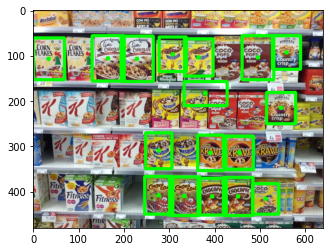

Product 0 - 1 Instances Found:
Instance 0 [ position: ((311.5,325.5), width: 57 px, height: 73 px]
Product 1 - 1 Instances Found:
Instance 1 [ position: ((367.5,329.0), width: 57 px, height: 70 px]
Product 3 - 2 Instances Found:
Instance 3 [ position: ((298.0,428.0), width: 72 px, height: 82 px]
Instance 3 [ position: ((246.0,421.5), width: 64 px, height: 81 px]
Product 4 - 2 Instances Found:
Instance 4 [ position: ((203.0,131.5), width: 70 px, height: 97 px]
Instance 4 [ position: ((141.5,130.0), width: 69 px, height: 96 px]
Product 5 - 1 Instances Found:
Instance 5 [ position: ((331.5,122.0), width: 57 px, height: 76 px]
Product 7 - 1 Instances Found:
Instance 7 [ position: ((373.0,238.5), width: 58 px, height: 83 px]
Product 9 - 1 Instances Found:
Instance 9 [ position: ((402.0,59.0), width: 64 px, height: 80 px]
Product 11 - 2 Instances Found:
Instance 11 [ position: ((426.0,329.5), width: 60 px, height: 71 px]
Instance 11 [ position: ((367.5,330.0), width: 57 px, height: 68 px]
Pr

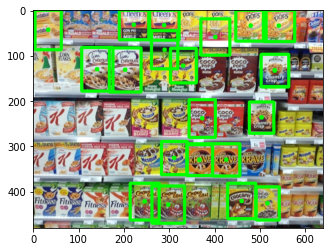

Product 0 - 1 Instances Found:
Instance 0 [ position: ((404.5,311.5), width: 57 px, height: 73 px]
Product 1 - 1 Instances Found:
Instance 1 [ position: ((462.5,314.5), width: 59 px, height: 71 px]
Product 3 - 3 Instances Found:
Instance 3 [ position: ((455.5,410.5), width: 67 px, height: 81 px]
Instance 3 [ position: ((396.0,409.0), width: 66 px, height: 80 px]
Instance 3 [ position: ((340.5,404.5), width: 61 px, height: 81 px]
Product 4 - 2 Instances Found:
Instance 4 [ position: ((301.0,120.0), width: 64 px, height: 94 px]
Instance 4 [ position: ((243.5,121.0), width: 63 px, height: 92 px]
Product 5 - 1 Instances Found:
Instance 5 [ position: ((425.0,114.0), width: 62 px, height: 82 px]
Product 8 - 1 Instances Found:
Instance 8 [ position: ((471.5,233.5), width: 83 px, height: 83 px]
Product 9 - 1 Instances Found:
Instance 9 [ position: ((130.5,255.5), width: 59 px, height: 55 px]
Product 11 - 3 Instances Found:
Instance 11 [ position: ((584.5,319.5), width: 65 px, height: 73 px]
In

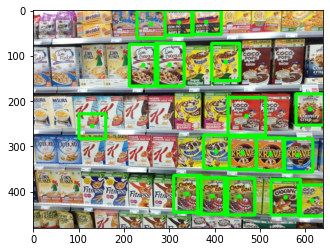

Product 1 - 2 Instances Found:
Instance 1 [ position: ((447.0,337.0), width: 60 px, height: 76 px]
Instance 1 [ position: ((387.5,337.5), width: 59 px, height: 75 px]
Product 2 - 1 Instances Found:
Instance 2 [ position: ((83.5,130.0), width: 69 px, height: 96 px]
Product 3 - 2 Instances Found:
Instance 3 [ position: ((325.5,442.5), width: 73 px, height: 89 px]
Instance 3 [ position: ((265.5,440.5), width: 69 px, height: 89 px]
Product 5 - 2 Instances Found:
Instance 5 [ position: ((288.5,124.0), width: 61 px, height: 84 px]
Instance 5 [ position: ((354.0,118.5), width: 60 px, height: 81 px]
Product 8 - 1 Instances Found:
Instance 8 [ position: ((400.0,237.0), width: 90 px, height: 96 px]
Product 11 - 2 Instances Found:
Instance 11 [ position: ((387.0,338.5), width: 60 px, height: 77 px]
Instance 11 [ position: ((448.5,337.0), width: 59 px, height: 76 px]
Product 14 - 2 Instances Found:
Instance 14 [ position: ((445.0,438.5), width: 64 px, height: 91 px]
Instance 14 [ position: ((389.5

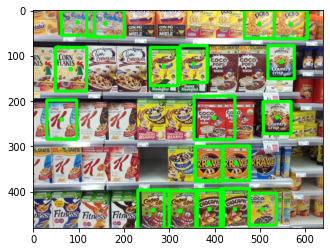

Product 0 - 2 Instances Found:
Instance 0 [ position: ((221.5,338.5), width: 61 px, height: 75 px]
Instance 0 [ position: ((283.0,337.5), width: 60 px, height: 75 px]
Product 1 - 1 Instances Found:
Instance 1 [ position: ((344.5,344.0), width: 65 px, height: 72 px]
Product 3 - 3 Instances Found:
Instance 3 [ position: ((337.0,443.0), width: 68 px, height: 84 px]
Instance 3 [ position: ((216.5,441.5), width: 67 px, height: 83 px]
Instance 3 [ position: ((277.5,444.0), width: 65 px, height: 82 px]
Product 5 - 2 Instances Found:
Instance 5 [ position: ((237.5,127.0), width: 59 px, height: 82 px]
Instance 5 [ position: ((302.5,126.0), width: 59 px, height: 80 px]
Product 11 - 2 Instances Found:
Instance 11 [ position: ((403.5,347.0), width: 63 px, height: 72 px]
Instance 11 [ position: ((343.0,345.0), width: 60 px, height: 72 px]
Product 14 - 1 Instances Found:
Instance 14 [ position: ((434.0,430.0), width: 62 px, height: 82 px]
Product 15 - 1 Instances Found:
Instance 15 [ position: ((493

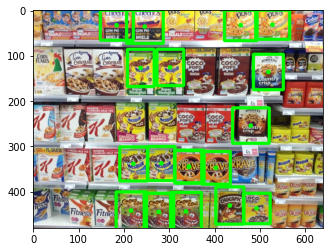

In [11]:
def object_retrieve(query_idx,img_query, img_train, query_features, train_features, min_match_count = 5, COLOR_DIFF_THRESHOLD = 100, verbose = False):
    rectangles = []
    # Partition the keypoints of train image into clusters
    labels,n_clusters = cluster_kp(train_features[0])
    for i in range(n_clusters):
      # Compute the matches on the subset of keypoints
      key_train_local = np.array(train_features[0])[labels == i]
      des_train_local = np.array(train_features[1])[labels == i]
      good = compute_matches(0,5,50,2,0.7,des_train_local,query_features[1])
      # If it's a good match, then proceed with the detection
      if len(good)>min_match_count:
          src_pts = np.float32([query_features[0][m.queryIdx].pt for m in good ]).reshape(-1,1,2)
          dst_pts = np.float32([key_train_local[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
          M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)
          if M is None:
              pass
          else:
              h,w,_ = img_query.shape
              # Generate and plot the rectangle into the target image
              pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
              dst = cv2.perspectiveTransform(pts,M)
              roi,start,end = get_roi(dst[0][0][0],dst[1][0][0],dst[2][0][0],dst[3][0][0],dst[0][0][1],dst[1][0][1],dst[2][0][1],dst[3][0][1],img_train)
              # If we can manage to obtain a rectangle, then we proceed
              if len(roi):
                # check if the euclidean distance between the colors (mean) of the two rectangle is lower than the chosen threshold
                color_diff = np.linalg.norm(roi.mean(axis = 0).mean(axis = 0) - img_query.mean(axis = 0).mean(axis = 0))
                if color_diff <= COLOR_DIFF_THRESHOLD:
                    rectangles.append((start,end))
    
    # If there were multiple detection for the same roi, we discard them with non maxima suppression
    centroids,rectangles = non_maxima_suppression(np.array(rectangles),img_train.shape)
    if len(rectangles):
      print_output(query_idx,rectangles,img_train)
    return rectangles



pred_labels = {}
#Iterating among all scenes and looking for the query object.
for index_train in range(len(train_images)):
  scene_labels = []
  dump = train_images[index_train].copy()
  for index_query in range(len(query_images)):
    scene_labels.append(object_retrieve(index_query,query_images[index_query], train_images[index_train], query_features[index_query], train_features[index_train]))
  imgplot = plt.imshow(train_images[index_train])
  plt.show()
  pred_labels[index_train] = scene_labels
  train_images[index_train] = dump
